In [73]:
from leagues.models import Competition,Season
from base_app.helpers import best_fuzzy_match
from metrics.helpers.infered_carry import infer_carries_with_confidence 
from metrics.phases.attack import AttackPhase
from games.models import Game
from base_app.models import ConfigItems,OptaEvents,OptaQualifier

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from PIL import Image
from datetime import datetime
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

## 0. Setting Up with configs and reusables

In [76]:
results = {
    'field_tilt' : [],
    'attacking_3rd_entry_team' : [],
    'attacking_3rd_entry_player' : [],
    'total_xt' : [],
    'progressive_zone' : [],
    'vericality' : [],
    'offensive_width' : [],
    'centrality' : [],
    'shooting_team' : [],
    'shooting_player' : []
}
BASE_FILES = r'D:/Aggregated_Files/AFC/India/Indian_Super_League/2024-2025/Attack'
ICN_FILES = r'D:/Aggregated_Files/AFC/India/Indian_Super_League/2024-2025/Icons'
BASE_ASSET_PATH = r'D:\Aggregated_Files\AFC\India\Indian_Super_League\2024-2025\Assets'

TEAM_ICON = {
    'Mumbai City FC' : f"{ICN_FILES}/mumbai.png",
    'Mohun Bagan Super Giant' : f"{ICN_FILES}/mbsg.png",
    'Chennaiyin FC' : f"{ICN_FILES}/chennai.png",
    'Odisha FC' : f"{ICN_FILES}/odisa.png",
    'East Bengal FC' : f"{ICN_FILES}/eb.png",
    'Bengaluru FC' : f"{ICN_FILES}/blr.png",
    'Punjab FC' : f"{ICN_FILES}/punjab.png",
    'Kerala Blasters FC' : f"{ICN_FILES}/kerela.png",
    'Mohammedan SC' : f"{ICN_FILES}/mohammedan.png",
    'NorthEast United FC' : f"{ICN_FILES}/neu.png",
    'FC Goa' : f"{ICN_FILES}/goa.png",
    'Jamshedpur FC' : f"{ICN_FILES}/jamshedpur.png",
    'Hyderabad FC' : f"{ICN_FILES}/hyderabad.png",
    'SC Delhi' : f"{ICN_FILES}/hyderabad.png",
    'Inter Kashi FC' : f"{ICN_FILES}/kashi.png",
}

In [77]:
dfs = {}
for k,v in results.items() :
    p = f"{BASE_FILES}/{k}.csv"
    dfs[k] = pd.read_csv(p)

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

def set_plot_style():
    # Base seaborn theme
    sns.set_theme(
        style="whitegrid",
        context="talk",
        font_scale=1.0
    )

    # Default color cycle
    plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#0F766E",
        "#115E59",
        "#134E4A",
        "#166534",
        "#15803D",
        "#16A34A",
        "#22C55E",
        "#4ADE80",
        "#86EFAC",
        "#D9F99D",
        "#FEF08A",
        "#FACC15",
        ]
    )


    # Global rcParams
    plt.rcParams.update({
        # ---- Backgrounds ----
        "figure.facecolor": "#323232",
        "axes.facecolor": "#323232",
        "savefig.facecolor": "#323232",

        # ---- Grid ----
        "axes.grid": True,
        "grid.color": "#555555",
        "grid.linestyle": "--",
        "grid.alpha": 0.5,

        # ---- Spines ----
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.edgecolor": "#A0A0A0",

        # ---- Text ----
        "text.color": "#EAEAEA",
        "axes.titlecolor": "#f0f0f0",     # title
        "axes.labelcolor": "#D0D0D0",     # x & y labels
        "xtick.color": "#B0B0B0",
        "ytick.color": "#B0B0B0",

        # ---- Sizes ----
        "axes.titlesize": 16,
        "axes.labelsize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,

        # ---- Figure ----
        "figure.figsize": (18, 10),
        "savefig.bbox": "tight",
    })

set_plot_style()
DEFAULT_COLOR = {
    'highlight' : "yellowgreen",
    'highlight_1' : "#b3cd32",
    'highlight_2' : "#32cd82",
    "bad" : "crimson",
    "caution" : "goldenrod"
}

In [79]:
from PIL import Image
import numpy as np
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def replace_xlabels_with_icons(
    ax,
    labels,
    icon_map,
    icon_px=(32, 32),
    y_axis_offset=-0.05   # 👈 negative = below axis
):
    """
    Replace x-axis labels with icons placed BELOW the axis.
    """

    ax.set_xticklabels([])
    ax.set_xlabel("")

    for i, label in enumerate(labels):
        if label not in icon_map:
            continue

        img = Image.open(icon_map[label]).convert("RGBA")
        img = img.resize(icon_px, Image.LANCZOS)
        img = np.asarray(img)

        imagebox = OffsetImage(img, zoom=1.0)

        ab = AnnotationBbox(
            imagebox,
            (i, y_axis_offset),
            xycoords=ax.get_xaxis_transform(),  # 🔥 THIS FIX
            frameon=False,
            box_alignment=(0.5, 1)
        )

        ax.add_artist(ab)
from PIL import Image
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def replace_ylabels_with_icons(
    ax,
    labels,
    icon_map,
    icon_px=(28, 28),
    x_axis_offset=-0.08
):
    """
    Replace y-axis tick labels with icons.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
    labels : list
        Ordered list of y-axis labels (top to bottom)
    icon_map : dict
        {label: image_path}
    icon_px : tuple
        (width, height) in pixels
    x_axis_offset : float
        Negative moves icons left of axis
    """

    ax.set_yticklabels([])
    ax.set_ylabel("")

    for i, label in enumerate(labels):
        if label not in icon_map:
            continue

        img = Image.open(icon_map[label]).convert("RGBA")
        img = img.resize(icon_px, Image.LANCZOS)
        img = np.asarray(img)

        imagebox = OffsetImage(img, zoom=1.0)

        ab = AnnotationBbox(
            imagebox,
            (x_axis_offset, i),
            xycoords=ax.get_yaxis_transform(),  # 🔥 lock to y-axis
            frameon=False,
            box_alignment=(1, 0.5)
        )

        ax.add_artist(ab)
def annotate_with_icons(
    ax,
    df,
    x_col,
    y_col,
    label_col,
    icon_map,
    icon_px=(28, 28),
    xy_offset=(0, 0)
):
    """
    Annotate data points with icons.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
    df : pd.DataFrame
        Data containing x, y, and labels
    x_col : str
        Column name for x values
    y_col : str
        Column name for y values
    label_col : str
        Column used to match icons (e.g. team)
    icon_map : dict
        {label: icon_path}
    icon_px : tuple
        (width, height) in pixels
    xy_offset : tuple
        (dx, dy) offset in data coordinates
    """

    for _, r in df.iterrows():
        label = r[label_col]
        if label not in icon_map:
            continue

        img = Image.open(icon_map[label]).convert("RGBA")
        img = img.resize(icon_px, Image.LANCZOS)
        img = np.asarray(img)

        imagebox = OffsetImage(img, zoom=1.0)

        ab = AnnotationBbox(
            imagebox,
            (r[x_col] + xy_offset[0], r[y_col] + xy_offset[1]),
            frameon=False
        )

        ax.add_artist(ab)


## 1. Field Tilt

In [80]:
dfs['field_tilt']

,game_id,team,field_tilt
0,2796,Mumbai City FC,63.59
1,2796,Mohun Bagan Super Giant,36.41
2,2797,Chennaiyin FC,71.98
3,2797,Odisha FC,28.02
4,2798,East Bengal FC,53.50
...,...,...,...
321,2956,Bengaluru FC,35.50
322,2957,Mohun Bagan Super Giant,87.85
323,2957,Jamshedpur FC,12.15
324,2958,Bengaluru FC,53.61


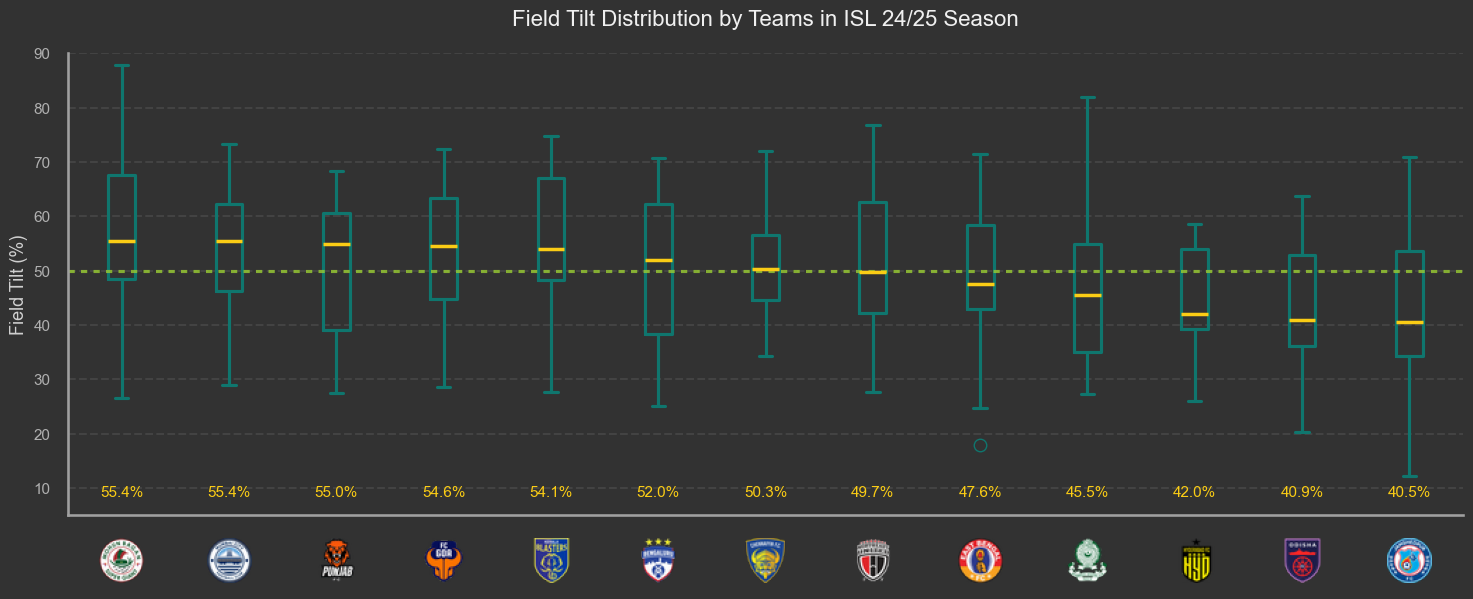

In [81]:
fig, ax = plt.subplots(figsize=(18, 6))

# Compute medians and order
median_series = (
    dfs["field_tilt"]
    .groupby("team")["field_tilt"]
    .median()
    .sort_values(ascending=False)
)

team_order = median_series.index.tolist()
dfs['shooting_team']
sns.boxplot(
    data=dfs["field_tilt"],
    x="team",
    y="field_tilt",
    order=team_order,
    width=0.25,
    fill=False,
    ax=ax,
    medianprops=dict(
        color="#FACC15",      # 🔥 highlight median bar
        linewidth=2.5
    ),
    # whiskerprops=dict(color="#16A34A"),
    # capprops=dict(color="#16A34A"),
    # boxprops=dict(color="#16A34A")
)

# Reference line
ax.axhline(50, color="yellowgreen", dashes=(2, 2), alpha=0.8)
 # ---- place median values near bottom ----
y_min, y_max = ax.get_ylim()
# y_text = y_min + 0.03 * (y_max - y_min)   # fixed relative position
y_text = y_min -0.5   # fixed relative position

for i, team in enumerate(team_order):
    median_val = median_series.loc[team]
    ax.text(
        i,
        y_text,
        f"{median_val:.1f}%",
        ha="center",
        va="bottom",
        fontsize=11,
        color="#FACC15"
    )

ax.set_ylabel("Field Tilt (%)")
ax.set_xlabel("")
ax.set_title(
    "Field Tilt Distribution by Teams in ISL 24/25 Season",
    pad=20
)

# Icons (same order)
replace_xlabels_with_icons(
    ax=ax,
    labels=team_order,
    icon_map=TEAM_ICON,
    icon_px=(32, 32)
)
ax.set_ylim(5, 90)
#
# plt.tight_layout()
plt.savefig(rf'{BASE_ASSET_PATH}\League_Field_tilt_distribution.png')
plt.show()

## 2.Entrys into final third

In [82]:
df = dfs['attacking_3rd_entry_team'].groupby('team').agg(
    total_xT_p90 = ('Total_xT','mean'),
    pass_xT_p90 = ('xT_pass','mean'),
    carry_xT_p90 = ('xT_carry','mean'),
    total_actions_p90 = ('total_actions','mean'),
    successful_action_p90 = ('successful_action','mean'),
    failed_actions_p90 = ('failed_actions','mean'),
    total_carries_p90 = ('total_carries','mean'),
    xT_per_action_p90 = ('xT_per_action','mean'),
    
    total_xT_med = ('Total_xT','median'),
    pass_xT_med = ('xT_pass','median'),
    carry_xT_med = ('xT_carry','median'),
    total_actions_med = ('total_actions','median'),
    successful_action_med = ('successful_action','median'),
    failed_actions_med = ('failed_actions','median'),
    total_carries_med = ('total_carries','median'),
    xT_per_action_med = ('xT_per_action','median') 
).reset_index().copy()
df.columns

Index(['team', 'total_xT_p90', 'pass_xT_p90', 'carry_xT_p90',
       'total_actions_p90', 'successful_action_p90', 'failed_actions_p90',
       'total_carries_p90', 'xT_per_action_p90', 'total_xT_med', 'pass_xT_med',
       'carry_xT_med', 'total_actions_med', 'successful_action_med',
       'failed_actions_med', 'total_carries_med', 'xT_per_action_med'],
      dtype='object')

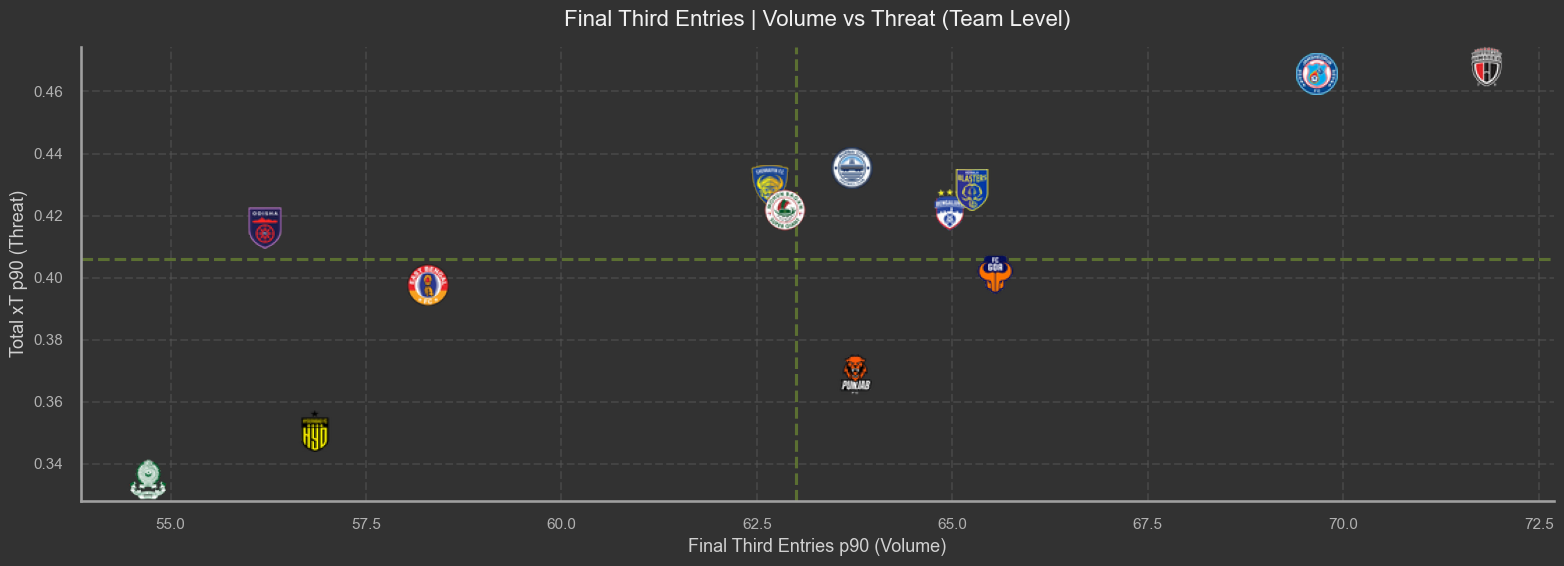

In [83]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.scatter(
    df["total_actions_p90"],
    df["total_xT_p90"],
    s=2,
    alpha=0.6
)
x_med = df["total_actions_med"].median()
y_med = df["total_xT_med"].median()

x_min, x_max = ax.get_xlim()
y_min, y_max = ax.get_ylim()
# Median reference lines
ax.axvline(x_med, linestyle="--",color=DEFAULT_COLOR['highlight'],alpha=0.4)
ax.axhline(y_med, linestyle="--",color=DEFAULT_COLOR['highlight'], alpha=0.4)

ax.set_xlabel("Final Third Entries p90 (Volume)")
ax.set_ylabel("Total xT p90 (Threat)")
ax.set_title("Final Third Entries | Volume vs Threat (Team Level)", pad=15)

annotate_with_icons(
    ax=ax,
    df=df,
    x_col="total_actions_p90",
    y_col="total_xT_p90",
    label_col="team",
    icon_map=TEAM_ICON,
    icon_px=(30, 30),
    xy_offset=(0, 0)
)

# # Quadrant labels
# ax.text(
#     x_min + 0.05 * (x_max - x_min),
#     y_med + 0.15 * (y_max - y_min),
#     "Less entries\nHigh threat",
#     fontsize=11,
#     alpha=0.8
# )

# ax.text(
#     x_max - 0.1 * (x_max - x_min),
#     y_med + 0.05 * (y_max - y_min),
#     "More entries\nHigh threat",
#     fontsize=11,
#     alpha=0.8
# )

# ax.text(
#     x_min + 0.05 * (x_max - x_min),
#     y_med - 0.15 * (y_max - y_min),
#     "Less entries\nLow threat",
#     fontsize=11,
#     alpha=0.8
# )

# ax.text(
#     x_max - 0.1 * (x_max - x_min),
#     y_med - 0.15 * (y_max - y_min),
#     "More entries\nLow threat",
#     fontsize=11,
#     alpha=0.8
# )

plt.tight_layout()
plt.savefig(f"{BASE_ASSET_PATH}/Final_third_entry_Volume_vs_Threat.png")
plt.show()


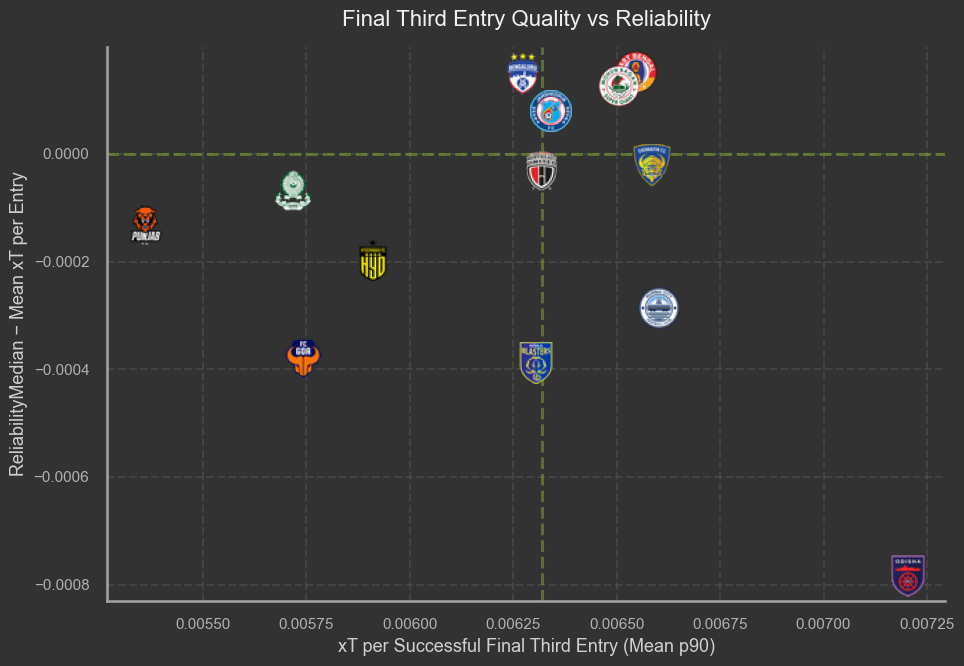

In [84]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

fig, ax = plt.subplots(figsize=(10, 7))
df["reliability_gap"] = df["xT_per_action_med"] - df["xT_per_action_p90"]

# Scatter (invisible points, icons will sit here)
ax.scatter(
    df["xT_per_action_p90"],
    df["reliability_gap"],
    s=10,
    alpha=0
)

# Reference lines
ax.axhline(0, linestyle="--",color=DEFAULT_COLOR['highlight'],alpha=0.4)
ax.axvline(df["xT_per_action_p90"].median(), linestyle="--",color=DEFAULT_COLOR['highlight'], alpha=0.4)

ax.set_xlabel("xT per Successful Final Third Entry (Mean p90)")
ax.set_ylabel("ReliabilityMedian − Mean xT per Entry")
ax.set_title("Final Third Entry Quality vs Reliability", pad=15)

# Annotate with icons
annotate_with_icons(
    ax=ax,
    df=df,
    x_col="xT_per_action_p90",
    y_col="reliability_gap",
    label_col="team",
    icon_map=TEAM_ICON,
    icon_px=(30, 30)
)

plt.tight_layout()
plt.show()


## 3. xT Geneartion

In [104]:
df = dfs['total_xt'].groupby('team').agg(
    total_actions_p90 = ('total_actions','mean'),
    total_pos_actions_p90 = ('total_pos_actions','mean'),
    total_neg_actions_p90 = ('total_neg_actions','mean'),
    pos_def_action_p90 = ('pos_def_action','mean'),
    neg_def_action_p90 = ('neg_def_action','mean'),
    pos_mid_action_p90 = ('pos_mid_action','mean'),
    neg_mid_action_p90 = ('neg_mid_action','mean'),
    pos_att_action_p90 = ('pos_att_action','mean'),
    neg_att_action_p90 = ('neg_att_action','mean'),
    total_xT_p90 = ('total_xT','mean'),
    pos_xT_p90 = ('pos_xT','mean'),
    neg_xT_p90 = ('neg_xT','mean'),
    pos_def_xt_p90 = ('pos_def_xt','mean'),
    neg_def_xt_p90 = ('neg_def_xt','mean'),
    pos_mid_xt_p90 = ('pos_mid_xt','mean'),
    neg_mid_xt_p90 = ('neg_mid_xt','mean'),
    pos_att_xt_p90 = ('pos_att_xt','mean'),
    neg_att_xt_p90 = ('neg_att_xt','mean'),

    total_actions_med = ('total_actions','median'),
    total_pos_actions_med = ('total_pos_actions','median'),
    total_neg_actions_med = ('total_neg_actions','median'),
    pos_def_action_med = ('pos_def_action','median'),
    neg_def_action_med = ('neg_def_action','median'),
    pos_mid_action_med = ('pos_mid_action','median'),
    neg_mid_action_med = ('neg_mid_action','median'),
    pos_att_action_med = ('pos_att_action','median'),
    neg_att_action_med = ('neg_att_action','median'),
    total_xT_med = ('total_xT','median'),
    pos_xT_med = ('pos_xT','median'),
    neg_xT_med = ('neg_xT','median'),
    pos_def_xt_med = ('pos_def_xt','median'),
    neg_def_xt_med = ('neg_def_xt','median'),
    pos_mid_xt_med = ('pos_mid_xt','median'),
    neg_mid_xt_med = ('neg_mid_xt','median'),
    pos_att_xt_med = ('pos_att_xt','median'),
    neg_att_xt_med = ('neg_att_xt','median'),
).reset_index().copy()

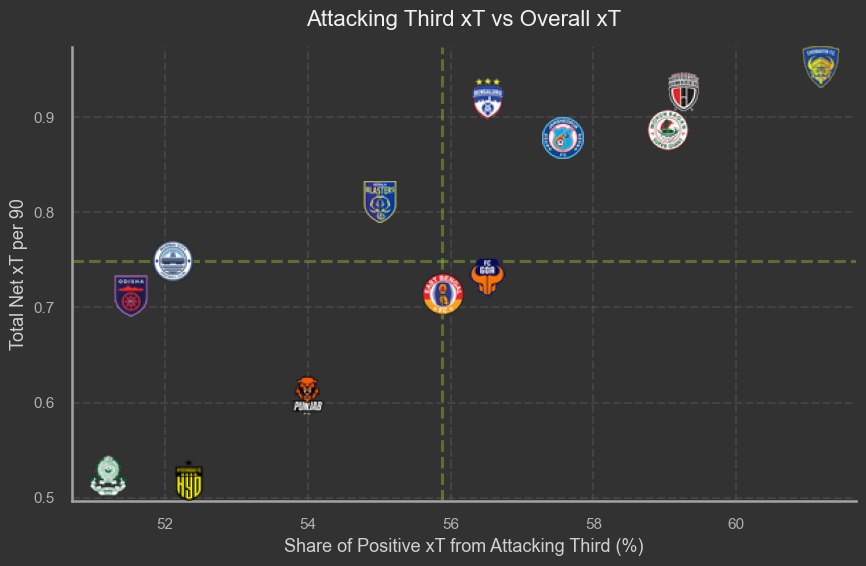

In [140]:
fig, ax = plt.subplots(figsize=(9, 6))
df_v = df.copy()
# Invisible scatter to set axes
ax.scatter(
    df_v["att_dependency"],
    df_v["total_xT_p90"],
    s=10,
    alpha=0
)

# Quadrant reference lines
ax.axvline(df_v["att_dependency"].median(), linestyle="--",color=DEFAULT_COLOR['highlight'], alpha=0.4)
ax.axhline(df_v["total_xT_p90"].median(), linestyle="--",color=DEFAULT_COLOR['highlight'], alpha=0.4)

ax.set_xlabel("Share of Positive xT from Attacking Third (%)")
ax.set_ylabel("Total Net xT per 90")
ax.set_title(
    "Attacking Third xT vs Overall xT",
    pad=15
)

# 🔥 Use YOUR existing function here
annotate_with_icons(
    ax=ax,
    df=df_v,
    x_col="att_dependency",
    y_col="total_xT_p90",
    label_col="team",
    icon_map=TEAM_ICON,
    icon_px=(30, 30),
    xy_offset=(0, 0)
)

plt.tight_layout()
plt.savefig(f"{BASE_ASSET_PATH}/Attacking_Third_xT_vs_Overall_xT.png")
plt.show()


## 4. Progression Zones

In [182]:
df = dfs['progressive_zone']
df.head()

,index,team,start_zone,end_zone,count,pct_of_team,cum_pct,game_id
0,0,Mohun Bagan Super Giant,mid_right,final_right_wing,7,9.72,9.72,2796
1,1,Mohun Bagan Super Giant,mid_left,mid_central,6,8.33,18.05,2796
2,2,Mohun Bagan Super Giant,def_right,mid_right,6,8.33,26.38,2796
3,3,Mohun Bagan Super Giant,def_left,mid_left,5,6.94,33.32,2796
4,4,Mohun Bagan Super Giant,def_central,mid_right,5,6.94,40.26,2796


In [183]:
agg_df = (
    df
    .groupby(['team', 'start_zone', 'end_zone'])
    .agg(
        total_actions=('count', 'sum')
    )
    .reset_index()
)

agg_df['pct'] = (
    (
        agg_df['total_actions'] /
        agg_df.groupby('team')['total_actions'].transform('sum')
    ) * 100
).round(2)
agg_df.head()

,team,start_zone,end_zone,total_actions,pct
0,Bengaluru FC,def_central,final_central,3,0.18
1,Bengaluru FC,def_central,final_right_half_space,7,0.41
2,Bengaluru FC,def_central,final_right_wing,13,0.76
3,Bengaluru FC,def_central,mid_central,127,7.46
4,Bengaluru FC,def_central,mid_left,102,5.99


In [214]:
def get_top_progression_zones(
    progression_df,
    top_n=5
):
    """
    Returns top N progression routes per team
    and how much % of total progression they explain.

    Expected columns in progression_df:
    ['team', 'start_zone', 'end_zone', 'count', 'pct_of_team']
    """

    # sort routes by importance within each team
    ranked = (
        progression_df
        .sort_values(["team", "pct"], ascending=[True, False])
        .copy()
    )

    # rank within team
    ranked["rank"] = (
        ranked
        .groupby("team")["pct"]
        .rank(method="first", ascending=False)
    )

    # keep top N
    top_routes = ranked[ranked["rank"] <= top_n]

    # compute cumulative share
    summary = (
        top_routes
        .groupby("team")
        .agg(
            top_routes_pct=("pct", "sum"),
            num_routes=("pct", "count")
        )
        .reset_index()
    )

    return top_routes, summary
top,summary = get_top_progression_zones(agg_df)
top.head(8)

,team,start_zone,end_zone,total_actions,pct,rank
10,Bengaluru FC,def_right,mid_right,210,12.34,1.0
7,Bengaluru FC,def_left,mid_left,204,11.99,2.0
20,Bengaluru FC,mid_left,final_left_wing,200,11.75,3.0
24,Bengaluru FC,mid_right,final_right_wing,172,10.11,4.0
18,Bengaluru FC,mid_central,mid_right,153,8.99,5.0
34,Chennaiyin FC,def_right,mid_right,167,15.35,1.0
51,Chennaiyin FC,mid_left,final_left_wing,166,15.26,2.0
55,Chennaiyin FC,mid_right,final_right_wing,163,14.98,3.0


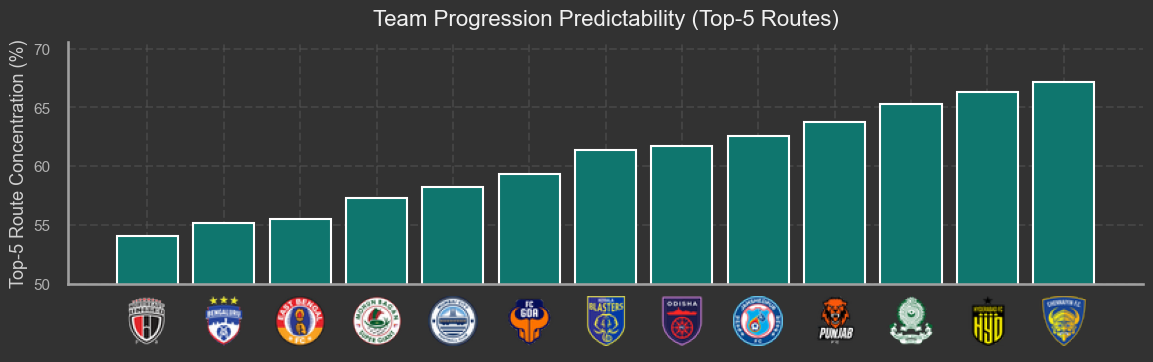

In [227]:
# --- Aggregate Top-5 concentration ---
top5_concentration = (
    top
    .groupby('team', as_index=False)
    .agg(top5_pct=('pct', 'sum'))
    .sort_values('top5_pct')
)

teams = top5_concentration['team'].tolist()

# --- Plot ---
fig, ax = plt.subplots(figsize=(12, 4))

ax.bar(
    range(len(top5_concentration)),
    top5_concentration['top5_pct']
)

ax.set_ylabel("Top-5 Route Concentration (%)")
ax.set_title("Team Progression Predictability (Top-5 Routes)", pad=12)

# --- Replace x labels with icons ---
ax.set_xticks(range(len(teams)))
ax.set_xticklabels(teams)

replace_xlabels_with_icons(
    ax=ax,
    labels=teams,
    icon_map=TEAM_ICON,
    icon_px=(36, 36)
)
ax.set_ylim(50, None)
plt.savefig(f"{BASE_ASSET_PATH}/Team_Progression_Predictability.png")
plt.tight_layout()
plt.show()


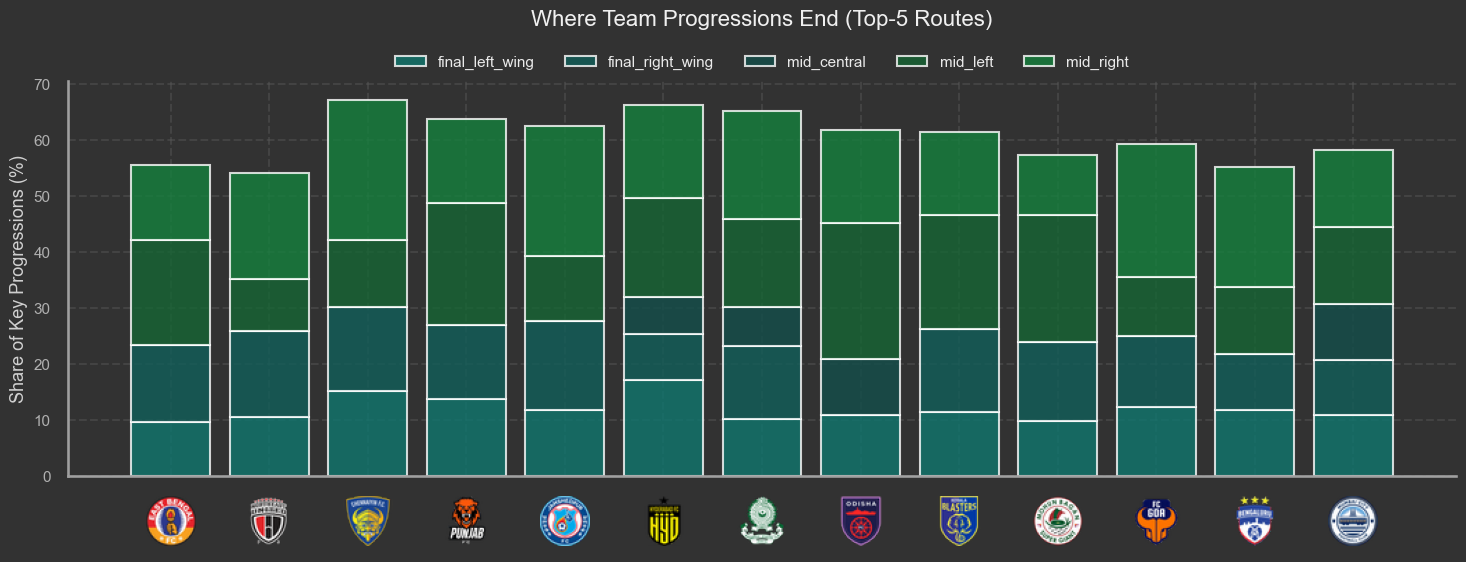

In [344]:
# --- 1. Overall progression volume per team ---
team_volume = (
    top
    .groupby('team', as_index=False)
    .agg(team_actions=('total_actions', 'sum'))
)

# --- 2. End-zone share from top-5 routes ---
end_zone_share = (
    top
    .groupby(['team', 'end_zone'], as_index=False)
    .agg(end_zone_pct=('pct', 'sum'))
)

# --- 3. Merge volume for sorting ---
end_zone_share = end_zone_share.merge(
    team_volume,
    on='team',
    how='left'
)

# --- 4. Pivot & sort by overall progression ---
pivot = (
    end_zone_share
    .pivot(index='team', columns='end_zone', values='end_zone_pct')
    .fillna(0)
)

pivot = pivot.loc[
    team_volume.sort_values('team_actions')['team']
]

teams = pivot.index.tolist()

# --- 5. Plot ---
fig, ax = plt.subplots(figsize=(15, 6))

bottom = np.zeros(len(pivot))

for zone in pivot.columns:
    ax.bar(
        range(len(pivot)),
        pivot[zone],
        bottom=bottom,
        label=zone,
        alpha=0.8
    )
    bottom += pivot[zone].values

ax.set_ylabel("Share of Key Progressions (%)")
ax.set_title("Where Team Progressions End (Top-5 Routes)", pad=40)
ax.legend(title="End Zone",loc='best')

# --- 6. Replace x labels with icons ---
ax.set_xticks(range(len(teams)))
ax.set_xticklabels(teams)
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10),
    ncol=5,
    frameon=False
)
replace_xlabels_with_icons(
    ax=ax,
    labels=teams,
    icon_map=TEAM_ICON,
    icon_px=(36, 36)
)
plt.savefig(f"{BASE_ASSET_PATH}/End_Zone_of_Team_Progression.png")
plt.tight_layout()
plt.show()


## 5. Verticality

In [260]:
team_vert = (
    dfs['vericality']
    .groupby('team', as_index=False)
    .agg(
        median_verticality_index=('vericalty_index', 'median'),
        median_vertical_dist=('median_vertical_dist', 'median'),
        avg_vertical_dist=('avg_vertical_dist','mean'),
        vertical_actions=('vertical_actions', 'sum'),
        non_vertical_actions=('non_vertical_actions', 'sum'),
        median_start_position=('median_start_position', 'median'),
        median_end_position=('median_end_position', 'median'),
    )
)

# Optional: recomputed vertical ratio
team_vert['vertical_action_ratio'] = ((
    team_vert['vertical_actions'] /
    (team_vert['vertical_actions'] + team_vert['non_vertical_actions'])
)*100
).round(2)
team_vert['median_vertical_dist'] = team_vert['median_vertical_dist']*1.2
team_vert['avg_vertical_dist'] = team_vert['avg_vertical_dist']*1.2
team_vert.head(8)

,team,median_verticality_index,median_vertical_dist,avg_vertical_dist,vertical_actions,non_vertical_actions,median_start_position,median_end_position,vertical_action_ratio
0,Bengaluru FC,0.473997,12.81,15.906361,4189,4581,45.275,51.000,47.77
1,Chennaiyin FC,0.534365,13.98,17.137771,2539,2249,51.575,59.225,53.03
2,East Bengal FC,0.528437,13.50,16.476532,2925,2751,50.750,58.000,51.53
3,FC Goa,0.500945,12.84,14.999453,4104,4111,49.900,55.500,49.96
4,Hyderabad FC,0.491275,12.84,15.200138,3168,3267,46.350,52.150,49.23
5,Jamshedpur FC,0.551402,14.04,17.423573,2876,2462,49.850,57.000,53.88
6,Kerala Blasters FC,0.497192,12.75,15.583465,3719,3884,48.475,53.200,48.91
7,Mohammedan SC,0.497601,12.75,15.600131,3103,3291,45.050,52.150,48.53


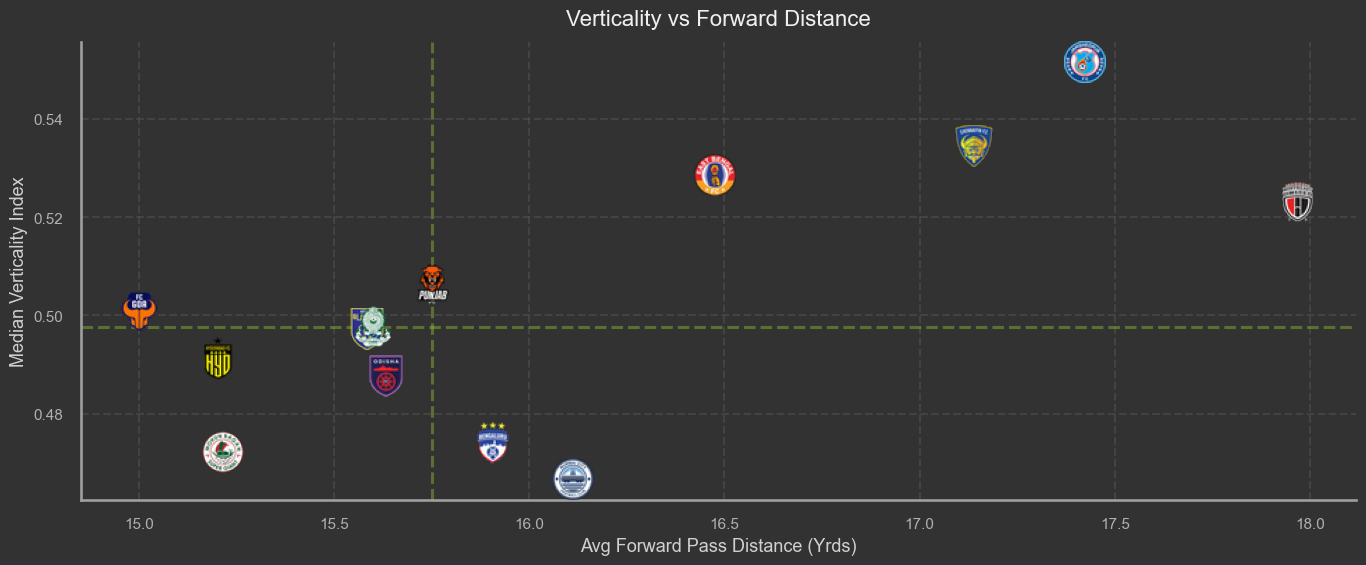

In [267]:
fig, ax = plt.subplots(figsize=(14, 6))

# Invisible scatter to set axes limits
ax.scatter(
    team_vert['avg_vertical_dist'],
    team_vert['median_verticality_index'],
    s=10,
    alpha=0
)

# League medians
x_med = team_vert['avg_vertical_dist'].median()
y_med = team_vert['median_verticality_index'].median()

ax.axvline(x_med, linestyle='--',color=DEFAULT_COLOR['highlight'], alpha=0.4)
ax.axhline(y_med, linestyle='--',color=DEFAULT_COLOR['highlight'], alpha=0.4)

ax.set_xlabel("Avg Forward Pass Distance (Yrds)")
ax.set_ylabel("Median Verticality Index")
ax.set_title("Verticality vs Forward Distance", pad=12)

# 🔥 Icons instead of dots
annotate_with_icons(
    ax=ax,
    df=team_vert,
    x_col='avg_vertical_dist',
    y_col='median_verticality_index',
    label_col='team',
    icon_map=TEAM_ICON,
    icon_px=(30, 30),
    xy_offset=(0, 0)
)
plt.tight_layout()
plt.savefig(f"{BASE_ASSET_PATH}/Verticality_vs_Forward_Distance.png")
plt.show()


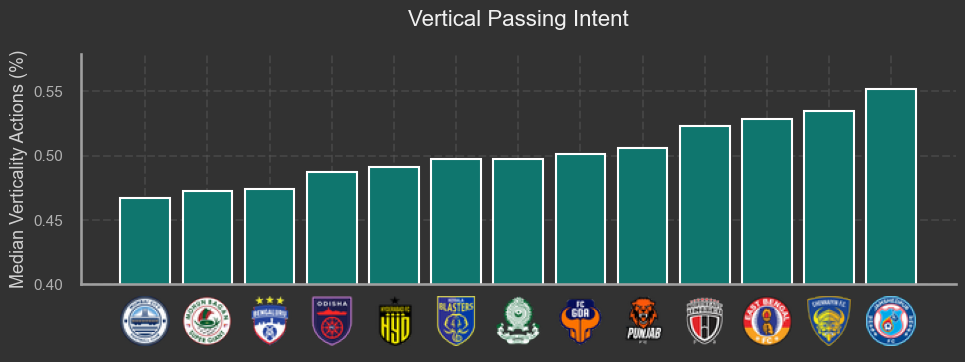

In [268]:
import matplotlib.pyplot as plt

# Sort teams by typical vertical intent
ranked = team_vert.sort_values('median_verticality_index')

teams = ranked['team'].tolist()

fig, ax = plt.subplots(figsize=(10, 4))

ax.bar(
    range(len(ranked)),
    ranked['median_verticality_index']
)

ax.set_ylabel("Median Verticality Actions (%)")
ax.set_title("Vertical Passing Intent", pad=20)

# Replace x labels with icons
ax.set_xticks(range(len(teams)))
ax.set_xticklabels(teams)

replace_xlabels_with_icons(
    ax=ax,
    labels=teams,
    icon_map=TEAM_ICON,
    icon_px=(36, 36)
)
ax.set_ylim(0.4,None)
plt.tight_layout()
plt.savefig(f"{BASE_ASSET_PATH}/Vertical_Passing_Intent.png")
plt.show()


## 6. Width of Attack

In [269]:
# plt.savefig(f"{BASE_ASSET_PATH}/Vertical_Passing_Intent.png")

In [439]:
import pandas as pd

# ---------- Region-level (median across matches) ----------
team_region = (
    dfs['offensive_width']
    .groupby(['team', 'region'], as_index=False)
    .agg(region_share=('region_presence', 'median'))
)

region_pivot = (
    team_region
    .pivot(index='team', columns='region', values='region_share')
    .fillna(0)
)

# Derived shares
region_pivot['wide_share'] = (
    region_pivot['left_wing'] + region_pivot['right_wing']
)

region_pivot['interior_share'] = (
    region_pivot['left_half_space']
    + region_pivot['central']
    + region_pivot['right_half_space']
)

# ---------- Side-level (median across matches) ----------
team_side = (
    dfs['offensive_width']
    .groupby(['team', 'side'], as_index=False)
    .agg(side_share=('side_presence', 'median'))
)

side_pivot = (
    team_side
    .pivot(index='team', columns='side', values='side_share')
    .fillna(0)
)

side_pivot['bias'] = side_pivot['right'] - side_pivot['left']


side_action
team                    side              
Bengaluru FC            left          5383
                        right         4913
Chennaiyin FC           left          3021
                        right         2827
East Bengal FC          left          3562
                        right         3305
FC Goa                  left          5033
                        right         4345
Hyderabad FC            left          4195
                        right         3403
Jamshedpur FC           left          3174
                        right         3197
Kerala Blasters FC      left          4453
                        right         4341
Mohammedan SC           left          3978
                        right         3843
Mohun Bagan Super Giant left          5422
                        right         4711
Mumbai City FC          left          5601
                        right         5105
NorthEast United FC     left          3584
                        right         3198
Odisha FC               left          4702
                        right         3949
Punjab FC               left          3686
                        right         3393

In [441]:
f = dfs['offensive_width'].groupby(['team','side']).agg(
    side_action = ('actions','sum')
)
f

side_action
team                    side              
Bengaluru FC            left          5383
                        right         4913
Chennaiyin FC           left          3021
                        right         2827
East Bengal FC          left          3562
                        right         3305
FC Goa                  left          5033
                        right         4345
Hyderabad FC            left          4195
                        right         3403
Jamshedpur FC           left          3174
                        right         3197
Kerala Blasters FC      left          4453
                        right         4341
Mohammedan SC           left          3978
                        right         3843
Mohun Bagan Super Giant left          5422
                        right         4711
Mumbai City FC          left          5601
                        right         5105
NorthEast United FC     left          3584
                        right         3198
Odisha FC               left          4702
                        right         3949
Punjab FC               left          3686
                        right         3393

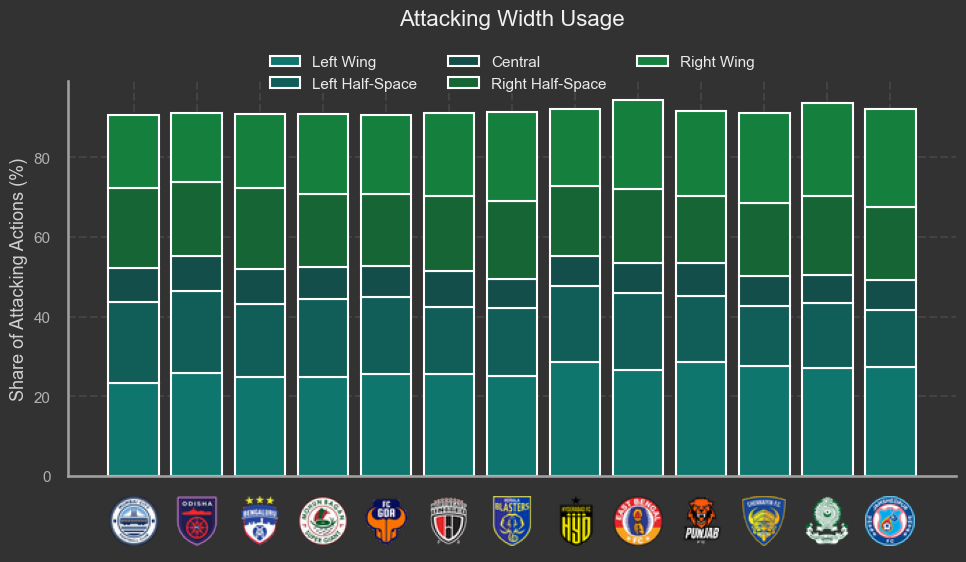

In [284]:
import numpy as np
import matplotlib.pyplot as plt

plot_df = region_pivot.sort_values('wide_share')

fig, ax = plt.subplots(figsize=(10, 6))

bottom = np.zeros(len(plot_df))

regions = [
    'left_wing',
    'left_half_space',
    'central',
    'right_half_space',
    'right_wing'
]

labels = [
    'Left Wing',
    'Left Half-Space',
    'Central',
    'Right Half-Space',
    'Right Wing'
]

# --- Stacked bars ---
for r, lab in zip(regions, labels):
    ax.bar(
        range(len(plot_df)),
        plot_df[r],
        bottom=bottom,
        label=lab
    )
    bottom += plot_df[r].values

# --- Axes & title ---
ax.set_ylabel("Share of Attacking Actions (%)")
ax.set_title("Attacking Width Usage", pad=40)

ax.set_xticks(range(len(plot_df)))
ax.set_xticklabels(plot_df.index)

# --- Legend: top, clean, not overlapping ---
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.10),
    ncol=3,
    frameon=False
)

# --- Replace x labels with icons ---
replace_xlabels_with_icons(
    ax=ax,
    labels=plot_df.index.tolist(),
    icon_map=TEAM_ICON,
    icon_px=(36, 36)
)

plt.tight_layout()
plt.show()


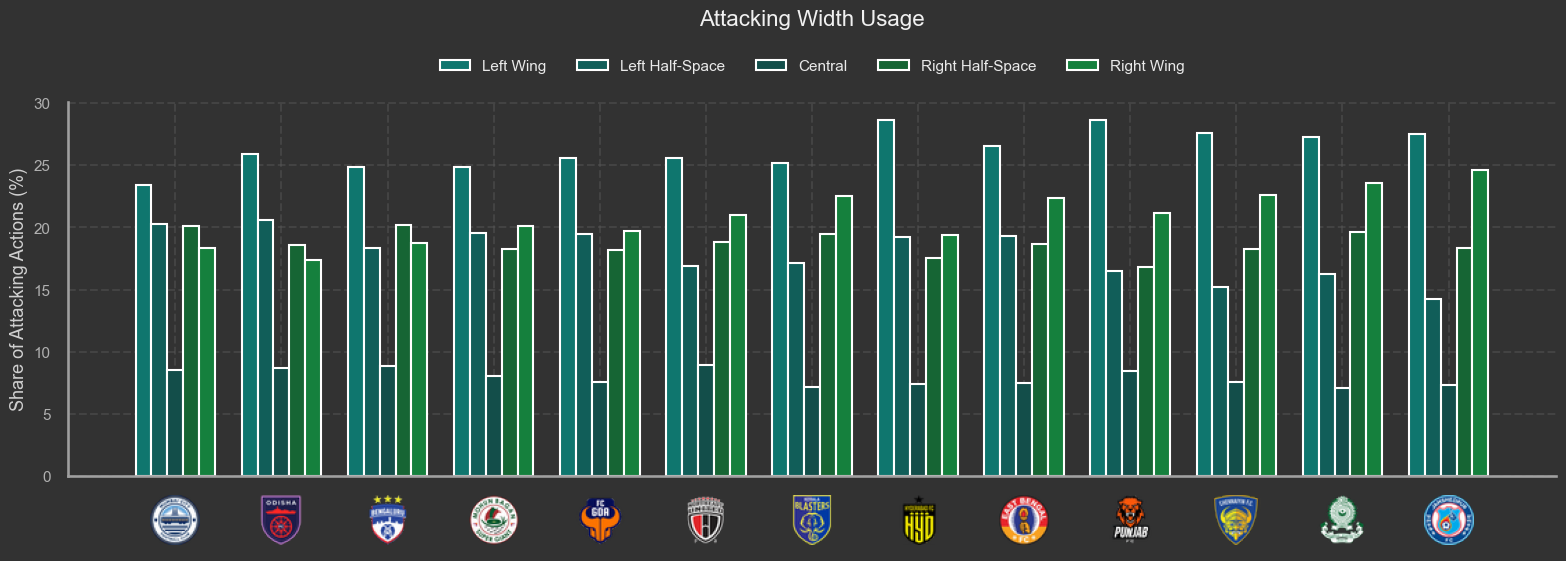

In [345]:
import numpy as np
import matplotlib.pyplot as plt

plot_df = region_pivot.sort_values('wide_share')

teams = plot_df.index.tolist()
x = np.arange(len(teams))
width = 0.15  # small width to fit 5 bars

fig, ax = plt.subplots(figsize=(16, 6))

regions = [
    ('left_wing', 'Left Wing', -2),
    ('left_half_space', 'Left Half-Space', -1),
    ('central', 'Central', 0),
    ('right_half_space', 'Right Half-Space', 1),
    ('right_wing', 'Right Wing', 2),
]

# --- Plot grouped bars ---
for col, label, offset in regions:
    ax.bar(
        x + offset * width,
        plot_df[col],
        width,
        label=label,
        edgecolor=None
    )

# --- Axes & title ---
ax.set_ylabel("Share of Attacking Actions (%)")
ax.set_title("Attacking Width Usage", pad=55)

ax.set_xticks(x)
ax.set_xticklabels(teams)

# --- Legend (top, compact) ---
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.15),
    ncol=5,
    frameon=False
)

# --- Replace labels with icons ---
replace_xlabels_with_icons(
    ax=ax,
    labels=teams,
    icon_map=TEAM_ICON,
    icon_px=(36, 36)
)

plt.tight_layout()
plt.savefig(f"{BASE_ASSET_PATH}/Share_of_Attacking_Actions.png")
plt.show()


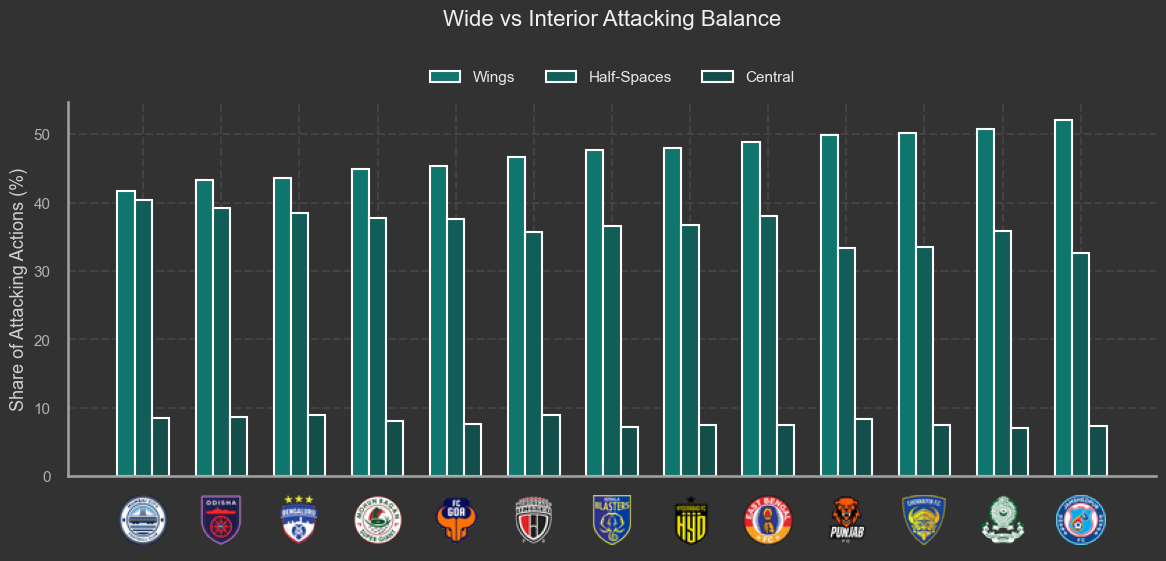

In [346]:
import numpy as np
import matplotlib.pyplot as plt

# --- Prepare data ---
plot_df = region_pivot.copy()

plot_df['wings'] = plot_df['left_wing'] + plot_df['right_wing']
plot_df['half_spaces'] = plot_df['left_half_space'] + plot_df['right_half_space']
plot_df['central_zone'] = plot_df['central']

# Sort by wing usage (stretching tendency)
plot_df = plot_df.sort_values('wings')

teams = plot_df.index.tolist()
x = np.arange(len(teams))
width = 0.22

fig, ax = plt.subplots(figsize=(12, 6))

# --- Grouped bars ---
ax.bar(
    x - width,
    plot_df['wings'],
    width,
    label='Wings'
)

ax.bar(
    x,
    plot_df['half_spaces'],
    width,
    label='Half-Spaces'
)

ax.bar(
    x + width,
    plot_df['central_zone'],
    width,
    label='Central'
)

# --- Axes & title ---
ax.set_ylabel("Share of Attacking Actions (%)")
ax.set_title("Wide vs Interior Attacking Balance", pad=55)

ax.set_xticks(x)
ax.set_xticklabels(teams)

# --- Legend ---
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=3,
    frameon=False
)

# --- Replace x labels with icons ---
replace_xlabels_with_icons(
    ax=ax,
    labels=teams,
    icon_map=TEAM_ICON,
    icon_px=(36, 36)
)

plt.tight_layout()
plt.savefig(f"{BASE_ASSET_PATH}/Wide_vs_Interior_Attacking_Balance.png")

plt.show()


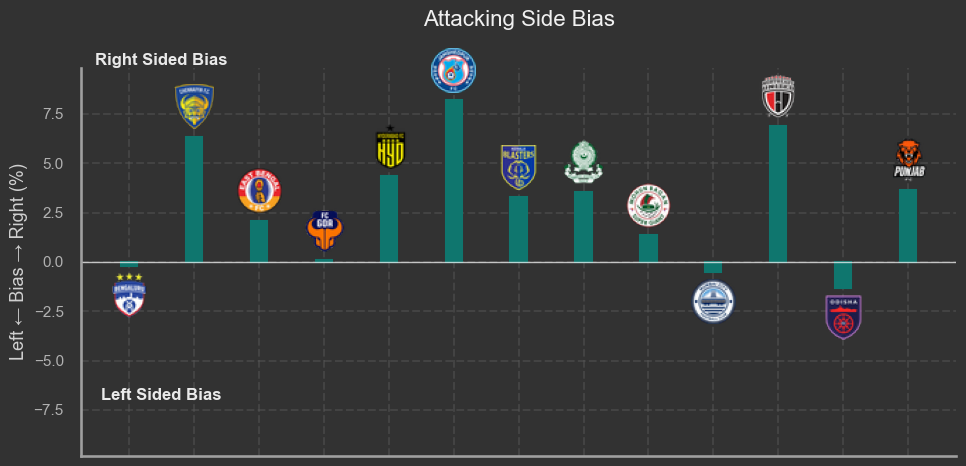

In [347]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

plot_df = side_pivot.copy().reset_index()

# Determine dominant side
plot_df['dominant'] = np.where(
    plot_df['left'] >= plot_df['right'],
    'left',
    'right'
)

# Excess-only bias (same logic you used)
plot_df['left_plot'] = np.where(
    plot_df['left'] > plot_df['right'],
    -(plot_df['left'] - plot_df['right']),
    0
)

plot_df['right_plot'] = np.where(
    plot_df['right'] > plot_df['left'],
    plot_df['right'] - plot_df['left'],
    0
)

# Total bias (single value per team)
plot_df['bias'] = plot_df['left_plot'] + plot_df['right_plot']

# X positions for teams
x = np.arange(len(plot_df))
plot_df['x_pos'] = x
plot_df['y_pos'] = plot_df['bias']

fig, ax = plt.subplots(figsize=(10, 5))

# --- Plot vertical bars ---
locations_icons = []
for i, row in plot_df.iterrows():
    ax.bar(
        i,
        row['bias'],
        width=0.25,
        color='#0F766E',
        edgecolor='#0F766E',
        fill=True,
        
    )
    locations_icons.append(row['bias'] -1.5 if row['bias'] < 0 else row['bias']+1.5)

# --- Center line (balanced) ---
ax.axhline(0, color='white', linewidth=1, alpha=0.7)

# --- Axes labels ---
ax.set_xticks(x)
ax.set_xticklabels([''] * len(x))
ax.set_ylabel("Left ← Bias → Right (%)")
ax.set_title("Attacking Side Bias", pad=30)

# --- Dynamic Y limits (IMPORTANT PART) ---
max_bias = plot_df['bias'].abs().max()
pad = max_bias * 0.2 if max_bias > 0 else 1

ax.set_ylim(
    -max_bias - pad,
     max_bias + pad
)

# --- Place team crests on x-axis (y=0) ---
plot_df['icon_y'] = locations_icons

annotate_with_icons(
    ax=ax,
    df=plot_df,
    x_col='x_pos',
    y_col='icon_y',
    label_col='team',
    icon_map=TEAM_ICON,
    icon_px=(32, 32)
)

ax.text(.5, 10, "Right Sided Bias", 
        fontsize=12, 
        fontweight='bold',
        ha='center')
ax.text(.5, -7, "Left Sided Bias", 
        fontsize=12, 
        fontweight='bold',
        ha='center')


# ax.legend(
#     handles=legend_handles,
#     loc='upper center',
#     bbox_to_anchor=(0.5, 1.10),
#     frameon=False
# )

plt.tight_layout()
plt.savefig(f"{BASE_ASSET_PATH}/Attacking_Side_Bias.png")
plt.show()


## 7. Centrality

In [361]:
df = dfs['centrality'].groupby('team').agg(
    total_final_third_actions = ('total_final_third_actions','sum'), 
    left_half_space_actions = ('left_half_space_actions','sum'), 
    right_half_space_actions = ('right_half_space_actions','sum'), 
    total_half_space_actions = ('total_half_space_actions','sum'), 
    zone14_actions = ('zone14_actions','sum'), 
    zone14_xG = ('zone14_xG','sum'), 
    zone14_xGOT = ('zone14_xGOT','sum'), 

    total_final_third_actions_p90 = ('total_final_third_actions','mean'), 
    left_half_space_actions_p90 = ('left_half_space_actions','mean'), 
    right_half_space_actions_p90 = ('right_half_space_actions','mean'), 
    total_half_space_actions_p90 = ('total_half_space_actions','mean'), 
    zone14_actions_p90 = ('zone14_actions','mean'), 
    zone14_xG_p90 = ('zone14_xG','mean'), 
    zone14_xGOT_p90 = ('zone14_xGOT','mean'), 
    
    total_final_third_actions_med = ('total_final_third_actions','median'), 
    left_half_space_actions_med = ('left_half_space_actions','median'), 
    right_half_space_actions_med = ('right_half_space_actions','median'), 
    total_half_space_actions_med = ('total_half_space_actions','median'), 
    zone14_actions_med = ('zone14_actions','median'), 
    zone14_xG_med = ('zone14_xG','median'), 
    zone14_xGOT_med = ('zone14_xGOT','median'), 

).reset_index()


In [370]:
df.columns

Index(['team', 'total_final_third_actions', 'left_half_space_actions',
       'right_half_space_actions', 'total_half_space_actions',
       'zone14_actions', 'zone14_xG', 'zone14_xGOT',
       'total_final_third_actions_p90', 'left_half_space_actions_p90',
       'right_half_space_actions_p90', 'total_half_space_actions_p90',
       'zone14_actions_p90', 'zone14_xG_p90', 'zone14_xGOT_p90',
       'total_final_third_actions_med', 'left_half_space_actions_med',
       'right_half_space_actions_med', 'total_half_space_actions_med',
       'zone14_actions_med', 'zone14_xG_med', 'zone14_xGOT_med'],
      dtype='object')

In [393]:
# x_values = df['total_final_third_actions_med'].values
df['central_actions_med'] = df['zone14_actions_med']+df['total_half_space_actions_med']

In [394]:
df['central_actions_med']

0     30.0
1     26.5
2     31.0
3     39.0
4     27.5
5     25.0
6     32.0
7     28.0
8     34.0
9     35.0
10    35.0
11    30.5
12    33.5
Name: central_actions_med, dtype: float64

In [389]:
# y_values.median()

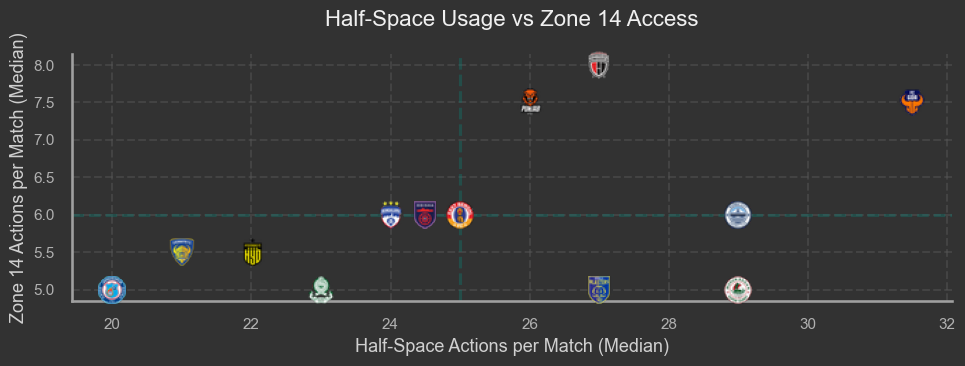

In [409]:
plot_df = df.copy()

# --- Column names (MUST exist) ---
x_col = 'total_half_space_actions_med'
y_col = 'zone14_actions_med'

fig, ax = plt.subplots(figsize=(10, 4))

# Invisible scatter to define limits
ax.scatter(
    plot_df[x_col].values,
    plot_df[y_col].values,
    alpha=0
)

# League medians
x_med = plot_df[x_col].median()
y_med = plot_df[y_col].median()

ax.axvline(x_med, linestyle='--', alpha=0.4)
ax.axhline(y_med, linestyle='--', alpha=0.4)

# Labels
ax.set_xlabel("Half-Space Actions per Match (Median)")
ax.set_ylabel("Zone 14 Actions per Match (Median)")
ax.set_title("Half-Space Usage vs Zone 14 Access", pad=20)

# Team icons
annotate_with_icons(
    ax=ax,
    df=plot_df,
    x_col=x_col,
    y_col=y_col,
    label_col='team',
    icon_map=TEAM_ICON,
    icon_px=(20, 20)
)

plt.tight_layout()
# ax.set_ylim(3,None)

plt.savefig(f"{BASE_ASSET_PATH}/Half-Space_Usage_vs_Zone_14_Access.png")

plt.show()


## 8. Shooting

In [417]:
# plt.savefig(f"{BASE_ASSET_PATH}/Half-Space_Usage_vs_Zone_14_Access.png")
df = dfs['shooting_team'].groupby('team').agg(
    shots = ('shots','sum') ,
goals = ('goals','sum') ,
own_goals = ('own_goals','sum') ,
shots_on_target = ('shots_on_target','sum') ,
xG = ('xG','sum') ,
xGOT = ('xGOT','sum') ,

    shots_p90 = ('shots','mean') ,
goals_p90 = ('goals','mean') ,
own_goals_p90 = ('own_goals','mean') ,
shots_on_target_p90 = ('shots_on_target','mean') ,
xG_p90 = ('xG','mean') ,
xGOT_p90 = ('xGOT','mean') ,

shots_med = ('shots','median') ,
goals_med = ('goals','median') ,
own_goals_med = ('own_goals','median') ,
shots_on_target_med = ('shots_on_target','median') ,
xG_med = ('xG','median') ,
xGOT_med = ('xGOT','median') ,
).reset_index()
df['goals_added'] = df['goals'] - df['xGOT']
df['goals_added_p90'] = df['goals_p90'] - df['xGOT_p90']
df['goals_added_med'] = df['goals_med'] - df['xGOT_med']

In [425]:
df[["team","goals_p90","xG_p90","xGOT_p90"]]

,team,goals_p90,xG_p90,xGOT_p90
0,Bengaluru FC,1.607143,1.212601,1.522061
1,Chennaiyin FC,1.333333,1.267333,1.300520
2,East Bengal FC,1.000000,1.064944,1.097129
3,FC Goa,1.615385,1.230798,1.281728
4,Hyderabad FC,0.916667,0.957363,0.931791
5,Jamshedpur FC,1.370370,1.286971,1.509661
6,Kerala Blasters FC,1.333333,1.178886,1.133749
7,Mohammedan SC,0.500000,1.041127,0.729517
8,Mohun Bagan Super Giant,1.814815,1.462810,1.575353
9,Mumbai City FC,1.120000,1.356360,1.201989


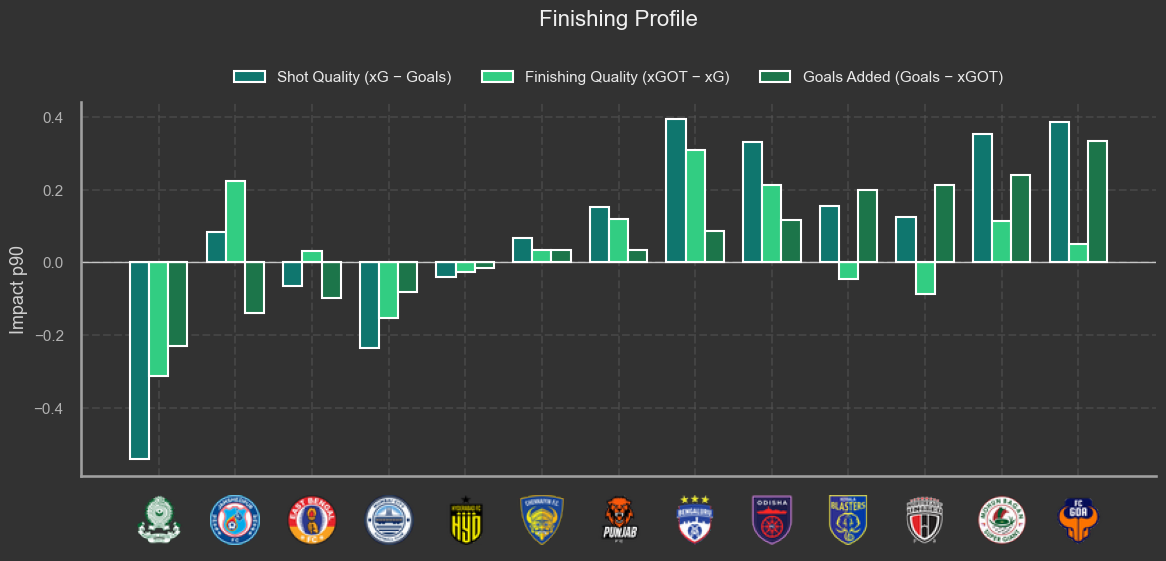

In [432]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- Prepare data (p90 only) ---
plot_df = df.copy()

plot_df['shot_quality'] = plot_df['goals_p90'] - plot_df['xG_p90']
plot_df['finishing_quality'] = plot_df['xGOT_p90'] - plot_df['xG_p90']
plot_df['goals_added_stage'] = plot_df['goals_added_p90']

# Order teams by net outcome (optional but helps reading)
plot_df = plot_df.sort_values('goals_added_stage')

teams = plot_df['team'].tolist()
x = np.arange(len(teams))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

# --- Bars (centered at 0) ---
ax.bar(
    x - width,
    plot_df['shot_quality'],
    width,
    label='Shot Quality (xG − Goals)'
)

ax.bar(
    x,
    plot_df['finishing_quality'],
    width,
    color="#32cd82",
    label='Finishing Quality (xGOT − xG)'
)

ax.bar(
    x + width,
    plot_df['goals_added_stage'],
    width,
    color="#1c754a",
    label='Goals Added (Goals − xGOT)'
)

# --- Reference line ---
ax.axhline(0, color='white', linewidth=1, alpha=0.7)

# --- Axes & title ---
ax.set_ylabel("Impact p90")
ax.set_title("Finishing Profile", pad=55)

ax.set_xticks(x)
ax.set_xticklabels(teams)

# --- Legend (top, clean) ---
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.12),
    ncol=3,
    frameon=False
)

# --- Replace x labels with team icons ---
replace_xlabels_with_icons(
    ax=ax,
    labels=teams,
    icon_map=TEAM_ICON,
    icon_px=(36, 36)
)
plt.savefig(f"{BASE_ASSET_PATH}/Finishing_Profile.png")

plt.tight_layout()
plt.show()
